In [223]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
import warnings

### Just test some models for now

### Import data

In [224]:
df = pd.read_csv('data/cleaned_data.csv')

In [225]:
df.head()

,Company,TypeName,Ram (GB),OpSys,Weight (kg),Width,Heigth,IsTouchscreen,CpuProducer,CpuSpeed (GHz),MemoryType,CombinedMemoryCapacity (GB),GpuProducer,Price_euros
0,Apple,Ultrabook,8,macOS,1.37,2560,1600,No,Intel,2.3,SSD,128,Intel,1339.69
1,Apple,Ultrabook,8,macOS,1.34,1440,900,No,Intel,1.8,Flash Storage,128,Intel,898.94
2,HP,Notebook,8,No OS,1.86,1920,1080,No,Intel,2.5,SSD,256,Intel,575.00
3,Apple,Ultrabook,16,macOS,1.83,2880,1800,No,Intel,2.7,SSD,512,AMD,2537.45
4,Apple,Ultrabook,8,macOS,1.37,2560,1600,No,Intel,3.1,SSD,256,Intel,1803.60


### Prepare X and y variables

In [226]:
X = df.drop(columns=['Price_euros'],axis=1)
y = df['Price_euros']

In [227]:
# define numerical & categorical columns
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

print('We have {} numerical features : {}'.format(len(num_features), num_features))
print('\nWe have {} categorical features : {}'.format(len(cat_features), cat_features))

We have 6 numerical features : Index(['Ram (GB)', 'Weight (kg)', 'Width', 'Heigth', 'CpuSpeed (GHz)',
       'CombinedMemoryCapacity (GB)'],
      dtype='object')

We have 7 categorical features : Index(['Company', 'TypeName', 'OpSys', 'IsTouchscreen', 'CpuProducer',
       'MemoryType', 'GpuProducer'],
      dtype='object')


In [228]:
def print_cat(feature):
    print(f"Categories in {feature} variable {len(X[feature].unique())}:      ",end=" " )
    print(X[feature].unique())


In [229]:
for feature in cat_features:
    print_cat(feature=feature)

Categories in Company variable 19:       ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']
Categories in TypeName variable 6:       ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']
Categories in OpSys variable 9:       ['macOS' 'No OS' 'Windows 10' 'Mac OS X' 'Linux' 'Android' 'Windows 10 S'
 'Chrome OS' 'Windows 7']
Categories in IsTouchscreen variable 2:       ['No' 'Yes']
Categories in CpuProducer variable 3:       ['Intel' 'AMD' 'Samsung']
Categories in MemoryType variable 9:       ['SSD' 'Flash Storage' 'HDD' 'SSD, HDD' 'SSD, SSD' 'Hybrid'
 'Flash Storage, HDD' 'HDD, HDD' 'SSD, Hybrid']
Categories in GpuProducer variable 4:       ['Intel' 'AMD' 'Nvidia' 'ARM']


In [230]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)


In [231]:
X = preprocessor.fit_transform(X)

In [232]:
X.shape

(1303, 58)

In [233]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)
X_train.shape, X_test.shape

((1042, 58), (261, 58))

### Create evaliation function 

In [234]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [235]:
models = {
    "Linear Regression": LinearRegression(),
    "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=5, weights='distance'),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=120, bootstrap=True, max_features='sqrt', random_state=1),
    # "XGBRegressor": XGBRegressor(), 
    # "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    # "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i, model_name in enumerate(models):
    model = models[model_name]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(model_name)
    model_list.append(model_name)
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 330.8035
- Mean Absolute Error: 237.1247
- R2 Score: 0.7751
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 307.2947
- Mean Absolute Error: 220.3972
- R2 Score: 0.8080


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 40.5848
- Mean Absolute Error: 8.6504
- R2 Score: 0.9966
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 313.0977
- Mean Absolute Error: 208.6086
- R2 Score: 0.8007


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 40.5848
- Mean Absolute Error: 8.6504
- R2 Score: 0.9966
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 375.4934
- Mean Absolute Error: 245.7933
- R2 Score: 0.7133


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 113.7504
- Mean Absolute Error: 72.

### Result

In [236]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
3,Random Forest Regressor,0.870050
0,Linear Regression,0.807976
1,K-Neighbors Regressor,0.800656
2,Decision Tree,0.713286


### Choose RandomforestRegressor

In [240]:
rf = RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt', random_state=1)
rf= rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 86.98


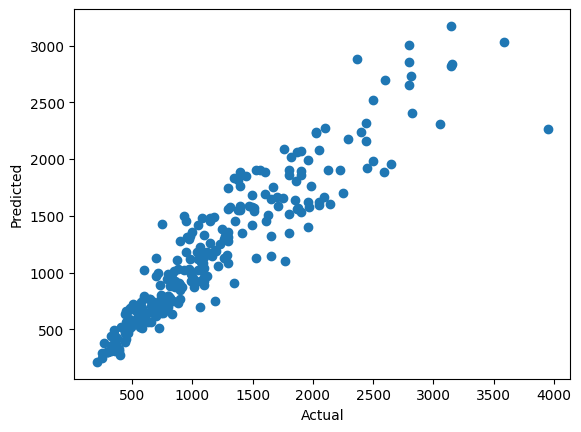

In [241]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

### Difference between predicted and actual values

In [242]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
644,450.00,411.028900,38.971100
1275,729.00,887.200000,-158.200000
163,1079.00,1478.960200,-399.960200
1008,1049.26,1024.293550,24.966450
909,1899.00,2068.785667,-169.785667
...,...,...,...
1112,429.00,507.282000,-78.282000
893,1799.00,1512.893900,286.106100
493,579.00,508.566400,70.433600
1245,1600.00,1888.925833,-288.925833
